In [1]:
import os
import pandas as pd


modelscoefficents = {}
rootdir = './RawData_RemovingNR'
for dir in os.listdir(rootdir):
    if os.path.isdir(os.path.join(rootdir, dir)):
        modelscoefficents[dir] = {}
        modelscoefficents[dir]["Setname"] = []
        modelscoefficents[dir]["ModelType"] = []
        modelscoefficents[dir]["FeatName"] = []
        modelscoefficents[dir]["CoeffValue"] = []
        modelscoefficents[dir]["FuncctionalBasisiSet"] = []
        for file in os.listdir(os.path.join(rootdir, dir)):
            if file == 'modelscoefficients.csv':
                fp = open(os.path.join(rootdir, dir, file), 'r')
                lines = fp.readlines()
                for l in lines:
                    if l.find(' PLS ') == -1:
                        sl = l.split(',')
                        if len(sl) !=  3:
                            print('ERROR in', os.path.join(rootdir, dir, file))
                            exit(-1)
                        else:
                            modelscoefficents[dir]["FuncctionalBasisiSet"].append(dir)
                            for idx, e in enumerate(sl):
                                e = e.strip()
                                if idx == 0:
                                    se = e.split(' ')
                                    setname  = ''
                                    modeltype = ''

                                    if len(se) == 2:
                                        setname  = se[0]
                                        modeltype = se[1]
                                    else:
                                        setname  = se[0]
                                        modeltype = ' '.join(se[1:])
                                    modelscoefficents[dir]["Setname"].append(setname)
                                    modelscoefficents[dir]["ModelType"].append(modeltype)
                                elif idx == 1:
                                    modelscoefficents[dir]["FeatName"].append(e)
                                elif idx == 2:
                                    cv = float(e)
                                    modelscoefficents[dir]["CoeffValue"].append(cv)
                fp.close()


In [2]:
# check unconverged models so with Coefficients = 1
for model in modelscoefficents:
    for idx, val in enumerate(modelscoefficents[model]["CoeffValue"]):
        if val == 1.0:
            print(model, modelscoefficents[model]["Setname"][idx],\
                   modelscoefficents[model]["ModelType"][idx], \
                    modelscoefficents[model]["FeatName"][idx], \
                        modelscoefficents[model]["CoeffValue"][idx])

In [3]:
# check sizes 
for model in modelscoefficents:
    assert len(modelscoefficents[model]["Setname"]) == len(modelscoefficents[model]["ModelType"])
    assert len(modelscoefficents[model]["Setname"]) == len(modelscoefficents[model]["FeatName"])
    assert len(modelscoefficents[model]["Setname"]) == len(modelscoefficents[model]["CoeffValue"])
    assert len(modelscoefficents[model]["Setname"]) == len(modelscoefficents[model]["FuncctionalBasisiSet"])

In [4]:
# transform Custom LR into MAPELR
for model in modelscoefficents:
    for idx, val in enumerate(modelscoefficents[model]["ModelType"]):
        if val == 'Custom LR':
            modelscoefficents[model]["ModelType"][idx] = 'MAPELR'
        elif val == 'Custom LR split':
            modelscoefficents[model]["ModelType"][idx] = 'MAPELR split'

In [5]:
modeltypes = set()
for model in modelscoefficents:
    for modeltype in modelscoefficents[model]["ModelType"]:
        modeltypes.add(modeltype)

for modeltype in modeltypes:
    print(modeltype)

LR
MAPELR split
LR split
MAPELR


In [6]:
# use only MAPELR and LR data for the analysis
toincludepermodel = {}
for model in modelscoefficents:
    toinclude = []
    for idx, val in enumerate(modelscoefficents[model]["ModelType"]):
        if val == 'MAPELR' or val == 'LR':
            toinclude.append(idx)
    toincludepermodel[model] = toinclude

# create a new dictionary with only MAPELR and LR data
modelscoefficentsnew = {}
for model in modelscoefficents:
    modelscoefficentsnew[model] = {}
    modelscoefficentsnew[model]["FuncctionalBasisiSet"] = []
    modelscoefficentsnew[model]["Setname"] = []
    modelscoefficentsnew[model]["ModelType"] = []
    modelscoefficentsnew[model]["FeatName"] = []
    modelscoefficentsnew[model]["CoeffValue"] = []
    for idx in toincludepermodel[model]:
        modelscoefficentsnew[model]["FuncctionalBasisiSet"].append(modelscoefficents[model]["FuncctionalBasisiSet"][idx])
        modelscoefficentsnew[model]["Setname"].append(modelscoefficents[model]["Setname"][idx])
        modelscoefficentsnew[model]["ModelType"].append(modelscoefficents[model]["ModelType"][idx])
        modelscoefficentsnew[model]["FeatName"].append(modelscoefficents[model]["FeatName"][idx])
        modelscoefficentsnew[model]["CoeffValue"].append(modelscoefficents[model]["CoeffValue"][idx])

def get_coefficents_for_featname(modelscoefficents, \
                                infuncbasis, \
                                looksetname, \
                                lookmodeltype, \
                                lookfeatname):
    coefficent = None
    for model in modelscoefficents:
        if model == infuncbasis:
            for idx, feat in enumerate(modelscoefficents[model]["FeatName"]):
                setname = modelscoefficents[model]["Setname"][idx]
                modeltyp = modelscoefficents[model]["ModelType"][idx]
                funcbasis = modelscoefficents[model]["FuncctionalBasisiSet"][idx]
                if (feat.find(lookfeatname) >= 0) \
                    and setname == looksetname and \
                    modeltyp == lookmodeltype and \
                    funcbasis == infuncbasis: # double check
                   coefficent = modelscoefficents[model]["CoeffValue"][idx]
    
    return coefficent

In [7]:
listfuncbasis = ["PBE_MINIX", "PBE_SVP", "PBE_TZVP", "PBE_QZVP", \
              "PBE0_MINIX", "PBE0_SVP", "PBE0_TZVP", "PBE0_QZVP",]
featuresnames = ["FSPE", "EC", "EX", "DC", "PE", "KE", "OEE", "TEE", "NR"]
featuresnames = ["FSPE", "EC", "EX", "DC", "PE", "KE", "OEE", "TEE"]
modeltypes = ["MAPELR"]
ssetnams = ["BARRIER_HEIGHTS", "INTRAMOLECULAR_INTERACTIONS", \
            "SMALL_MOLECULES", "INTERMOLECULAR_INTERACTIONS", \
            "LARGE_SYSTEMS", "Full"]

for mt in modeltypes:
    print(mt)
    for ssetnam in ssetnams:
        print("Feature (%10s) , "%(ssetnam), end='')
        for funcbasis in listfuncbasis:
            if funcbasis == listfuncbasis[-1]:
                print("%10s "%(funcbasis))
            else:
                print("%10s , "%(funcbasis), end='')
        
        for commonfeatname  in featuresnames + ["Intercept"]:
            print("%5s , "%(commonfeatname), end='')
            for funcbasis in listfuncbasis:
                coeff = get_coefficents_for_featname(modelscoefficentsnew, \
                                funcbasis, ssetnam, mt, commonfeatname)
                if funcbasis == listfuncbasis[-1]:
                    print(" %10.8f "%(coeff))
                else:
                    print(" %10.8f , "%(coeff) , end='')   
    print()

MAPELR
Feature (BARRIER_HEIGHTS) ,  PBE_MINIX ,    PBE_SVP ,   PBE_TZVP ,   PBE_QZVP , PBE0_MINIX ,   PBE0_SVP ,  PBE0_TZVP ,  PBE0_QZVP 
 FSPE ,  1.99716385 ,  1.00330531 ,  0.91180062 ,  0.76404979 ,  2.00690913 ,  0.86131996 ,  0.76787644 ,  0.58805508 
   EC ,  -2.18038842 ,  -1.32623339 ,  -1.01591660 ,  -1.02278030 ,  -1.70445478 ,  -0.84969175 ,  -0.68686545 ,  -0.60807370 
   EX ,  0.65844298 ,  0.33855344 ,  0.27269771 ,  0.21852629 ,  0.73294078 ,  0.24337097 ,  0.09598262 ,  0.12613078 
   DC ,  6.52591257 ,  3.28033194 ,  2.81917229 ,  2.20691766 ,  6.58545760 ,  2.75681347 ,  2.37617910 ,  1.75815379 
   PE ,  -1.28246988 ,  -0.14188054 ,  0.02499490 ,  0.24327279 ,  -1.30509433 ,  0.04863531 ,  0.19232713 ,  0.39976818 
   KE ,  -1.24628045 ,  -0.13514984 ,  0.06762427 ,  0.31387845 ,  -1.27348036 ,  0.05587646 ,  0.19931485 ,  0.43011569 
  OEE ,  0.00846847 ,  0.00478252 ,  0.00306320 ,  0.00275563 ,  0.00570160 ,  0.00439149 ,  0.00250107 ,  0.00105656 
  TEE ,  0.0171

In [8]:
# extract an equation given a startpoint, setname and modeltype
startpoint = 'PBE_SVP'
setname = 'BARRIER_HEIGHTS'
modeltype = 'MAPELR'

for sp in modelscoefficents:
    if sp == startpoint:
        for idx, sn in enumerate(modelscoefficents[sp]["Setname"]):
            mt = modelscoefficents[sp]["ModelType"][idx]
            fn = modelscoefficents[sp]["FeatName"][idx]
            cv = modelscoefficents[sp]["CoeffValue"][idx]
            if sn == setname and mt == modeltype:
                if fn == 'Intercept':
                    print(f'{cv:.8f}', end=' ')
                else:
                    if cv > 0:
                        print(f'+ {cv:.8f} * {fn}', end=' ')
                    else:
                        print(f'- {-cv:.8f} * {fn}', end=' ')
        print('')

0.48811697 - 1.32623339 * PBE_SVP_EC + 0.33855344 * PBE_SVP_EX + 1.00330531 * PBE_SVP_FSPE + 3.28033194 * PBE_SVP_DC - 0.14188054 * PBE_SVP_PE - 0.13514984 * PBE_SVP_KE + 0.00478252 * PBE_SVP_OEE + 0.00958549 * PBE_SVP_TEE 


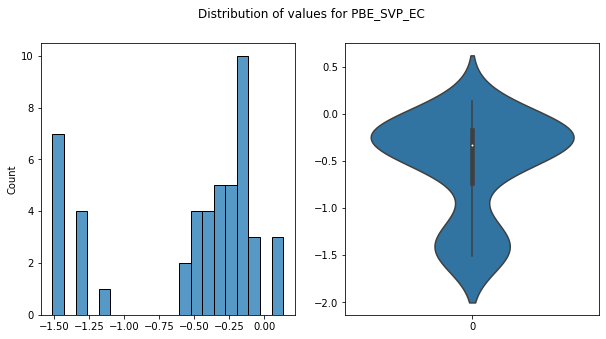

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_featurename_distribution (featname, plot=True):
    allvalues = []
    for sp in modelscoefficents:
        for idx, fn in enumerate(modelscoefficents[sp]["FeatName"]):
            if fn == featname:
                sn = modelscoefficents[sp]["Setname"][idx]
                mt = modelscoefficents[sp]["ModelType"][idx]
                cv = modelscoefficents[sp]["CoeffValue"][idx]
                allvalues.append(cv)
                #print(f'{sp} {sn} {mt} {cv:.8f}')

    # plot the distribution of the values


    # Create a boxplot
    #sns.set(style="whitegrid")
    #ax = sns.boxplot(allvalues)
    #plt.show()

    if not plot:
        return allvalues
    
    # create an histogram and a violin plot in the same figure
    plt.figure(figsize=(10, 5))
    # add a title to the plot
    plt.suptitle(f'Distribution of values for {featname}')
    plt.subplot(1, 2, 1)
    # create a histogram
    sns.histplot(allvalues, bins=20)
    plt.subplot(1, 2, 2)
    # create a violin plot
    sns.violinplot(data=allvalues)
    plt.show()

    return allvalues

# extract all values for a given featurename 
featname = 'PBE_SVP_EC'
allval = plot_featurename_distribution(featname)

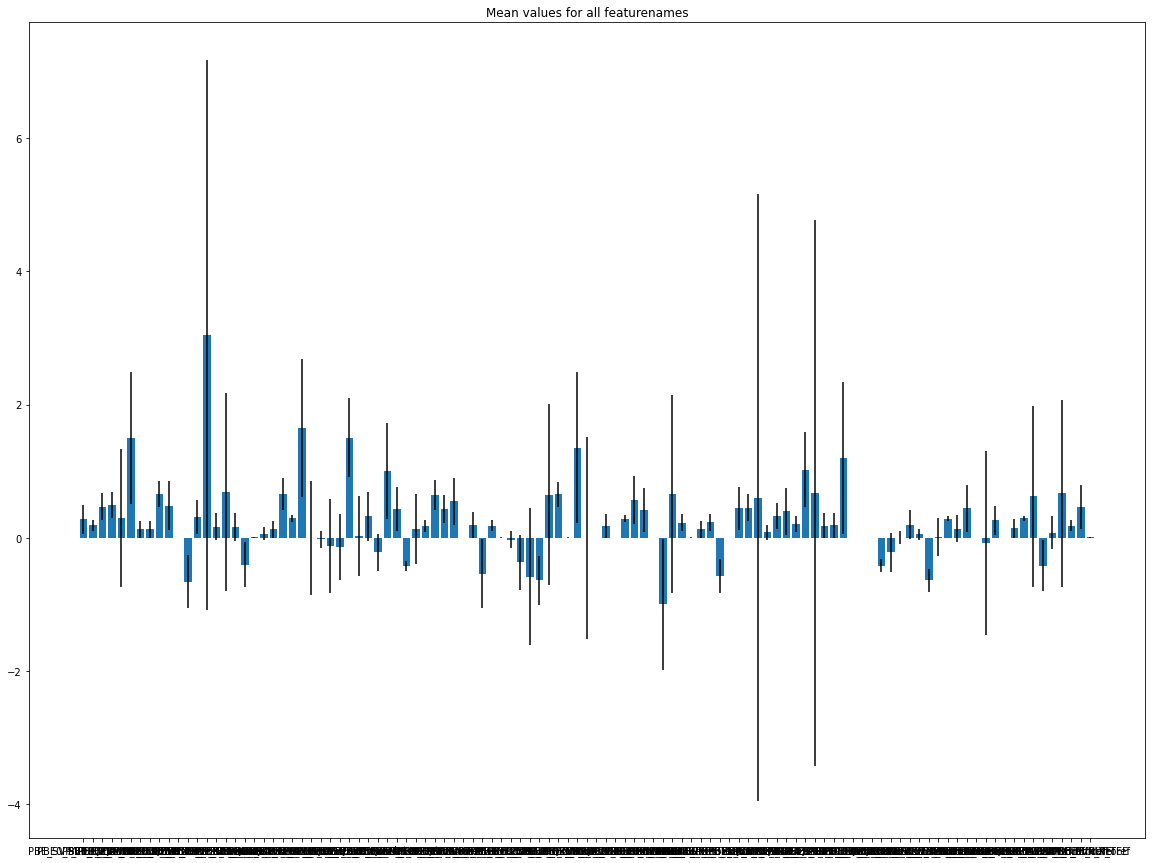

In [10]:
# extract all possible feature names
featnames = set()
avergesforfeatures = {}
for sp in modelscoefficents:
    for idx, fn in enumerate(modelscoefficents[sp]["FeatName"]):
        if fn not in featnames:
            featnames.add(fn)

for fn in featnames:
    allval = plot_featurename_distribution(fn, plot=False)
    avergesforfeatures[fn] = (np.mean(allval), 
                                min(allval), 
                                max(allval),  
                                np.std(allval),
                                len(allval))


#for fn in featnames:
#    print("%25s %11.8f %11.8f %11.8f %11.8f %3d" % (fn, \
#                avergesforfeatures[fn][0], \
#                avergesforfeatures[fn][1], \
#                avergesforfeatures[fn][2], \
#                avergesforfeatures[fn][3], \
#                avergesforfeatures[fn][4]))
# collect all meanvalues 
meanvalues = []
stdvalues = []
featurenames = []
for fn in featnames:
    meanvalues.append(avergesforfeatures[fn][0])
    stdvalues.append(avergesforfeatures[fn][3])
    featurenames.append(fn)

# plot the mean values 
plt.figure(figsize=(20, 15))
# add a title to the plot
plt.title(f'Mean values for all featurenames')
plt.bar(featurenames, meanvalues, yerr=stdvalues)
plt.show()

In [11]:
#for fn in featnames:
#    allval = plot_featurename_distribution(fn)
